**This code will generate the scanpath image for FreeViewing Task**
- Input:
    - img filename
    - participant name
    - window size

- Output:
    - scanpath image with fixation points

Caution: Recover the coordinates before plotting the scanpath image.

                        timestamp            left_gaze_point_on_display_area  \
37026  2024-04-23 19:38:33.252152    (0.688988447189331, 0.3229300379753113)   
37027  2024-04-23 19:38:33.269151    (0.686753511428833, 0.3218201994895935)   
37028  2024-04-23 19:38:33.286152    (0.683639407157898, 0.3151009976863861)   
37029  2024-04-23 19:38:33.302160  (0.6834883689880371, 0.31599605083465576)   
37030  2024-04-23 19:38:33.319160   (0.6804699301719666, 0.3214035630226135)   

       left_gaze_point_validity           right_gaze_point_on_display_area  \
37026                         1  (0.7117293477058411, 0.34551990032196045)   
37027                         1  (0.7111250162124634, 0.34670403599739075)   
37028                         1   (0.7122319340705872, 0.3409448266029358)   
37029                         1   (0.7127524614334106, 0.3409668505191803)   
37030                         1   (0.7134987115859985, 0.3457077145576477)   

       right_gaze_point_validity  left_pupil_diame

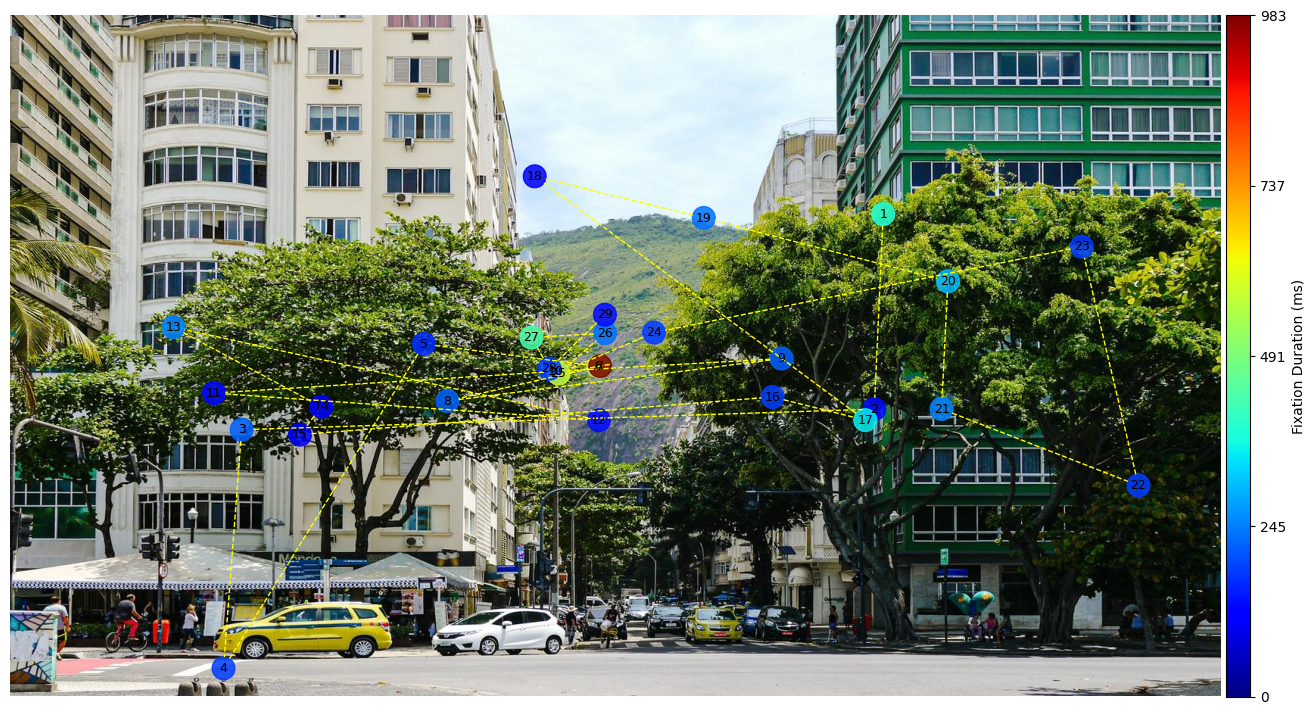

In [3]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import cv2
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

class GazeScanpath:
    def __init__(self, participant, image_name, window_size, display_width=1600, display_height=900, canvas_width=1600, canvas_height=900, alpha=0.85, circle_size=15):
        self.root_dir = '../../../'
        
        self.participant = participant
        self.image_name = image_name
        self.image_name_clean = image_name.split('.')[0]
        self.window_size = window_size
        self.window_frames = window_size * 60
        
        self.image_path = os.path.join(self.root_dir, 'Data_Collection/FreeViewing/Training/', self.image_name)
        self.display_width = display_width
        self.display_height = display_height
        self.canvas_width = canvas_width
        self.canvas_height = canvas_height
        self.alpha = alpha
        self.circle_size = circle_size
        
        self.input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{self.participant}_IMG_1.csv')
        self.output_filepath = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Scanpath', f'{self.participant}_{self.image_name_clean}_{self.window_size}sec.jpg')
        self.resize_image(self.image_path, self.display_width, self.display_height)
        self.gaze_data = None
        self.max_duration = None
        
        self.MW = None

    def resize_image(self, image_path, width, height):
        image = cv2.imread(image_path)
        if image is None:
            print("Failed to load image. Please check the image path.")
            return
        
        if image.shape[1] == self.display_width and image.shape[0] == self.display_height:
            pass
        else:
            # Resize the image
            resized_image = cv2.resize(image, (self.display_width, self.display_height))
            cv2.imwrite(image_path, resized_image)
            print(f"Image resized to {width}x{height} and saved with correct color.")
            
    def draw_display(self):
        screen = np.zeros((self.canvas_height, self.canvas_width, 3), dtype='float32')
        if self.image_path is not None:
            if not os.path.isfile(self.image_path):
                raise Exception(f"ERROR in draw_display: imagefile not found at '{self.image_path}'")
            # Load image with matplotlib's image module
            img = image.imread(self.image_path)
            # Ensure the image is in the correct format
            if img.dtype == np.float32:
                # Normalize if the image is in float format (common for .png)
                img = np.clip(img, 0, 1)
            elif img.dtype == np.uint8:
                # Convert to float and normalize if the image is in byte format (common for .jpg)
                img = img.astype('float32') / 255

            # width and height of the image
            w, h = img.shape[1], img.shape[0]
            # x and y position of the image on the display
            x = self.canvas_width // 2 - self.display_width // 2
            y = self.canvas_height // 2 - self.display_height // 2
            # draw the image on the screen
            screen[y:y + h, x:x + w, :] += img[:,:,:3]  # Use only RGB channels
        dpi = 100.0
        figsize = (self.canvas_width / dpi, self.canvas_height / dpi)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi, frameon=False)
        ax.set_axis_off()
        ax.axis([0, self.canvas_width, 0, self.canvas_height])
        ax.imshow(screen)
        return fig, ax            
            
    def draw_scanpath(self):
        fig, ax = self.draw_display()

        # Create a colormap instance
        jet_colormap = plt.cm.jet

        # Function to calculate distance between two points
        def distance(p1, p2):
            return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

        # Function to get a point on the line at a certain distance from a point
        def point_on_line(start, end, distance_from_start):
            line_length = distance(start, end)
            if line_length == 0:
                return start
            ratio = distance_from_start / line_length
            return start[0] + ratio * (end[0] - start[0]), start[1] + ratio * (end[1] - start[1])

        # Now draw the lines and circles
        for i in range(len(self.gaze_data) - 1):
            start = (self.gaze_data[i][0], self.gaze_data[i][1])
            end = (self.gaze_data[i + 1][0], self.gaze_data[i + 1][1])

            # Calculate points to start and end the line outside of the circles
            start_line = point_on_line(start, end, self.circle_size)
            end_line = point_on_line(end, start, self.circle_size)

            # Draw line
            line = plt.Line2D([start_line[0], end_line[0]], [start_line[1], end_line[1]], color='yellow', linestyle='--', linewidth=1)
            ax.add_line(line)

        # Draw circles and text
        for i in range(len(self.gaze_data)):
            x, y, duration = self.gaze_data[i]
            color_intensity = min(duration / self.max_duration, 1)  # Normalizing duration
            color = jet_colormap(color_intensity)[:3]  # Get RGB values from the colormap
            circle = plt.Circle((x, y), self.circle_size, color=color, alpha=self.alpha)
            ax.add_patch(circle)
            ax.text(x, y, str(i + 1), color='black', ha='center', va='center', fontsize=self.circle_size * 0.6)

        # Create a shorter legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=jet_colormap), cax=cax, orientation='vertical')
        cbar.set_label('Fixation Duration (ms)')
        # Set 5 ticks
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        ms_per_frame = 100 / 6  # 100 ms per 6 frames
        cbar.set_ticklabels(['0', f'{int(self.max_duration * 0.25 * ms_per_frame)}', f'{int(self.max_duration * 0.5 * ms_per_frame)}', f'{int(self.max_duration * 0.75 * ms_per_frame)}', f'{int(self.max_duration * ms_per_frame)}'])
        
        ax.invert_yaxis()
        if self.output_filepath is not None:
            fig.savefig(self.output_filepath)
        return fig

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6/5 * p[0] - 1/10, 6/5 * p[1] - 1/10)
    
    def to_pixel(self, coord):
        coord = eval(coord)
        if coord[0] == None or coord[1] == None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)
    
    def run(self):
        df = pd.read_csv(self.input_filepath, low_memory=False)
        condition = df['stimuli'] == self.image_name_clean
        selected_data = df[condition].iloc[-self.window_frames:]
        print(selected_data.head())
        
        self.MW = selected_data['state'].iloc[0] == 'num_6'
        
        fixation_center_list = selected_data['IVT_fixation_centroid'].apply(self.to_pixel).tolist()
        filtered_fixation_center_list = [coord for coord in fixation_center_list if coord != (None, None)]
        clean_fixation_center_list = []
        idx = 0
        while idx < len(filtered_fixation_center_list)-1:
            if filtered_fixation_center_list[idx] == filtered_fixation_center_list[idx+1]:
                start_idx = idx
                while idx < len(filtered_fixation_center_list)-1 and filtered_fixation_center_list[idx] == filtered_fixation_center_list[idx+1]:
                    idx += 1
                end_idx = idx
                clean_fixation_center_list.append((*filtered_fixation_center_list[start_idx], end_idx - start_idx + 1))
            else:
                clean_fixation_center_list.append((*filtered_fixation_center_list[idx], 1))
            idx += 1
        self.gaze_data = clean_fixation_center_list
        self.max_duration = max(self.gaze_data, key=lambda x:x[-1])[-1]
        self.draw_scanpath()


if __name__ == '__main__':
    participant = '15M'
    image_name = 'Brazil_1.jpg'
    window_size = 10 # seconds
    scanpath = GazeScanpath(participant, image_name, window_size)
    scanpath.run()


**This code below will generate the scanpath image for FreeViewing Task for all participants**
- Input:
    - img filename
    - window size

- Output:
    - scanpath image with fixation points

Caution: Recover the coordinates before plotting the scanpath image.

In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pandas as pd
import cv2
import math
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

class GazeScanpath:
    def __init__(self, participant, image_name, window_size, display_width=1600, display_height=900, alpha=0.85, circle_size=15):
        self.root_dir = '../../../'
        
        self.participant = participant
        self.image_name = image_name
        self.image_name_clean = image_name.split('.')[0]
        self.window_size = window_size
        self.window_frames = window_size * 60
        
        self.image_path = os.path.join(self.root_dir, 'Data_Collection/FreeViewing/Training/', self.image_name)
        self.display_width = display_width
        self.display_height = display_height
        self.alpha = alpha
        self.circle_size = circle_size
        
        self.input_filepath = os.path.join(self.root_dir, f'Preprocess/FreeViewing/Data/{self.participant}_IMG_1.csv')
        self.output_filedir = os.path.join(self.root_dir, 'Analysis/Visualization/FreeViewing/Result/Scanpath')
        self.output_filedir_mw = os.path.join(self.output_filedir, 'MW')
        self.output_filedir_focus = os.path.join(self.output_filedir, 'Focus')
        if not os.path.exists(self.output_filedir_mw): os.makedirs(self.output_filedir_mw)
        if not os.path.exists(self.output_filedir_focus): os.makedirs(self.output_filedir_focus)
        self.output_filepath = None
        
        self.resize_image(self.image_path, self.display_width, self.display_height)
        self.gaze_data = None
        self.max_duration = None
        
        self.MW = None

    def resize_image(self, image_path, width, height):
        image = cv2.imread(image_path)
        if image is None:
            print("Failed to load image. Please check the image path.")
            return
        
        if image.shape[1] == self.display_width and image.shape[0] == self.display_height:
            pass
        else:
            # Resize the image
            resized_image = cv2.resize(image, (self.display_width, self.display_height))
            cv2.imwrite(image_path, resized_image)
            print(f"Image resized to {width}x{height} and saved with correct color.")
            
    def draw_display(self):
        screen = np.zeros((self.display_height, self.display_width, 3), dtype='float32')
        if self.image_path is not None:
            if not os.path.isfile(self.image_path):
                raise Exception(f"ERROR in draw_display: imagefile not found at '{self.image_path}'")
            # Load image with matplotlib's image module
            img = image.imread(self.image_path)
            # Ensure the image is in the correct format
            if img.dtype == np.float32:
                # Normalize if the image is in float format (common for .png)
                img = np.clip(img, 0, 1)
            elif img.dtype == np.uint8:
                # Convert to float and normalize if the image is in byte format (common for .jpg)
                img = img.astype('float32') / 255

            # width and height of the image
            w, h = img.shape[1], img.shape[0]
            # x and y position of the image on the display
            x = self.display_width // 2 - w // 2
            y = self.display_height // 2 - h // 2
            # draw the image on the screen
            screen[y:y + h, x:x + w, :] += img[:,:,:3]  # Use only RGB channels
        dpi = 100.0
        figsize = (self.display_width / dpi, self.display_height / dpi)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi, frameon=False)
        ax.set_axis_off()
        ax.axis([0, self.display_width, 0, self.display_height])
        ax.imshow(screen)
        return fig, ax            
            
    def draw_scanpath(self):
        fig, ax = self.draw_display()

        # Create a colormap instance
        jet_colormap = plt.cm.jet

        # Function to calculate distance between two points
        def distance(p1, p2):
            return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

        # Function to get a point on the line at a certain distance from a point
        def point_on_line(start, end, distance_from_start):
            line_length = distance(start, end)
            if line_length == 0:
                return start
            ratio = distance_from_start / line_length
            return start[0] + ratio * (end[0] - start[0]), start[1] + ratio * (end[1] - start[1])

        # Now draw the lines and circles
        for i in range(len(self.gaze_data) - 1):
            start = (self.gaze_data[i][0], self.gaze_data[i][1])
            end = (self.gaze_data[i + 1][0], self.gaze_data[i + 1][1])

            # Calculate points to start and end the line outside of the circles
            start_line = point_on_line(start, end, self.circle_size)
            end_line = point_on_line(end, start, self.circle_size)

            # Draw line
            line = plt.Line2D([start_line[0], end_line[0]], [start_line[1], end_line[1]], color='yellow', linestyle='--', linewidth=1)
            ax.add_line(line)

        # Draw circles and text
        for i in range(len(self.gaze_data)):
            x, y, duration = self.gaze_data[i]
            color_intensity = min(duration / self.max_duration, 1)  # Normalizing duration
            color = jet_colormap(color_intensity)[:3]  # Get RGB values from the colormap
            circle = plt.Circle((x, y), self.circle_size, color=color, alpha=self.alpha)
            ax.add_patch(circle)
            ax.text(x, y, str(i + 1), color='black', ha='center', va='center', fontsize=self.circle_size * 0.6)

        # Create a shorter legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=jet_colormap), cax=cax, orientation='vertical')
        cbar.set_label('Fixation Duration (ms)')
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        ms_per_frame = 100 / 6  # 100 ms per 6 frames
        cbar.set_ticklabels(['0', f'{int(self.max_duration * 0.25 * ms_per_frame)}', f'{int(self.max_duration * 0.5 * ms_per_frame)}', f'{int(self.max_duration * 0.75 * ms_per_frame)}', f'{int(self.max_duration * ms_per_frame)}'])
        
        ax.invert_yaxis()
        if self.output_filepath is not None:
            fig.savefig(self.output_filepath)
            plt.close(fig)
        return fig

    # Function to scale the coordinates from 1600x900 to 1920x1080
    def transform_coordinate(self, p):
        return (6/5 * p[0] - 1/10, 6/5 * p[1] - 1/10)
    
    def to_pixel(self, coord):
        coord = eval(coord)
        if coord[0] == None or coord[1] == None: return (None, None)
        coord = self.transform_coordinate(coord)
        return (coord[0] * self.display_width, coord[1] * self.display_height)
    
    def run(self):
        df = pd.read_csv(self.input_filepath, low_memory=False)
        condition = df['stimuli'] == self.image_name_clean
        selected_data = df[condition].iloc[-self.window_frames:]
        self.MW = selected_data['state'].iloc[0] == 'num_6'
        if self.MW: self.output_filedir = self.output_filedir_mw
        else: self.output_filedir = self.output_filedir_focus
        self.output_filepath = os.path.join(self.output_filedir, f'{self.participant}_{self.image_name_clean}_{self.window_size}sec.jpg')
        
        fixation_center_list = selected_data['IVT_fixation_centroid'].apply(self.to_pixel).tolist()
        filtered_fixation_center_list = [coord for coord in fixation_center_list if coord != (None, None)]
        clean_fixation_center_list = []
        idx = 0
        while idx < len(filtered_fixation_center_list)-1:
            if filtered_fixation_center_list[idx] == filtered_fixation_center_list[idx+1]:
                start_idx = idx
                while idx < len(filtered_fixation_center_list)-1 and filtered_fixation_center_list[idx] == filtered_fixation_center_list[idx+1]:
                    idx += 1
                end_idx = idx
                clean_fixation_center_list.append((*filtered_fixation_center_list[start_idx], end_idx - start_idx + 1))
            else:
                clean_fixation_center_list.append((*filtered_fixation_center_list[idx], 1))
            idx += 1
        if not clean_fixation_center_list: 
            print(f"No data for {self.participant} on {self.image_name_clean}.")
            return
        self.gaze_data = clean_fixation_center_list
        self.max_duration = max(self.gaze_data, key=lambda x:x[-1])[-1]
        self.draw_scanpath()


if __name__ == '__main__':
    image_name = 'Brazil_1.jpg'
    window_size = 10 # seconds
    
    root_dir = '../../../'
    input_filedir = os.path.join(root_dir, 'Preprocess/FreeViewing/Data')
    output_filedir = os.path.join(root_dir, 'Analysis/Visualization/FreeViewing/Result/Scanpath')
    output_filedir_mw = os.path.join(output_filedir, 'MW')
    output_filedir_focus = os.path.join(output_filedir, 'Focus')
    if not os.path.exists(output_filedir_mw): os.makedirs(output_filedir_mw)
    if not os.path.exists(output_filedir_focus): os.makedirs(output_filedir_focus)
    
    for file_name in tqdm(os.listdir(input_filedir)):
        black_list = ["22K", "25I", "29N", "39Y"]
        if file_name.startswith('.') or file_name.split('_')[0] in black_list: 
            print(f"Skipping {file_name}")
            continue
        participant = file_name.split('_')[0]
        scanpath = GazeScanpath(participant, image_name, window_size)
        scanpath.run()

  0%|          | 0/41 [00:00<?, ?it/s]

Skipping .DS_Store


 20%|█▉        | 8/41 [00:02<00:11,  2.82it/s]

Skipping 22K_IMG_1.csv


 24%|██▍       | 10/41 [00:02<00:08,  3.78it/s]

Skipping 39Y_IMG_1.csv


 44%|████▍     | 18/41 [00:05<00:07,  3.14it/s]

Skipping 29N_IMG_1.csv


 71%|███████   | 29/41 [00:08<00:03,  3.24it/s]

Skipping 25I_IMG_1.csv


100%|██████████| 41/41 [00:12<00:00,  3.32it/s]
